In [ ]:
 import malaya
import spacy
from transformers import AutoTokenizer, AutoModelForTokenClassification
from flair.data import Sentence
from flair.models import SequenceTagger

# Load Malaya models
malaya_nlp = malaya

# Load SciSpacy model (medical / scientific terms)
scispacy_nlp = spacy.load("en_core_sci_sm")

# Load WikiAnn model using Flair
wikiann_tagger = SequenceTagger.load('flair/ner-multi-fast')



In [ ]:
text = "Bro barang ice dah sampai. Bank in dulu dekat Maybank account aku. Nanti jumpa bawah lrt pukul 3."


In [ ]:
# Language detection
lang = malaya_nlp.language_detection.fasttext.predict([text])
print("Detected Language:", lang[0])

# Keywords (keyphrases)
keywords = malaya_nlp.keyword.extractive.summarizer(text)
print("Keywords:", keywords)

# Sentiment (optional)
sentiment = malaya_nlp.sentiment.transformer(model='multinomial').predict([text])
print("Sentiment:", sentiment)

# Named Entity Recognition
malaya_entities = malaya_nlp.ner.transformer(model='bert').predict([text])
print("Malaya NER:", malaya_entities)


In [ ]:
doc = scispacy_nlp(text)
scispacy_ents = [(ent.text, ent.label_) for ent in doc.ents]
print("SciSpacy Entities:", scispacy_ents)


In [ ]:
sentence = Sentence(text)
wikiann_tagger.predict(sentence)
wikiann_entities = [(entity.text, entity.tag) for entity in sentence.get_spans('ner')]
print("WikiAnn Entities:", wikiann_entities)


In [ ]:
def combine_entities(malaya_entities, scispacy_ents, wikiann_entities):
    all_entities = []
    all_entities.extend(malaya_entities[0])  # first item in list for malaya
    all_entities.extend(scispacy_ents)
    all_entities.extend(wikiann_entities)
    return all_entities

combined = combine_entities(malaya_entities, scispacy_ents, wikiann_entities)
print("Combined Entities:")
for ent in combined:
    print(ent)


In [1]:
# Chat Crime Analysis Pipeline (Malaysia-focused)
# Dependencies: pandas, malaya, spacy, scispacy, transformers, flair

import pandas as pd
import malaya
import spacy
from transformers import AutoTokenizer, AutoModelForTokenClassification
from flair.data import Sentence
from flair.models import SequenceTagger
from datetime import datetime
import re

# Load Models
print("Loading models...")
malaya_ner = malaya.ner.transformer(model='bert')
malaya_sentiment = malaya.sentiment.transformer(model='multinomial')
malaya_keyword = malaya.keyword.extractive
lang_model = malaya.language_detection.fasttext
scispacy_nlp = spacy.load("en_core_sci_sm")
wikiann_tagger = SequenceTagger.load('flair/ner-multi-fast')

# Crime slang and keywords (expandable)
drug_keywords = ['ice', 'ubat', 'barang', 'lori', 'pil', 'kristal']
scam_keywords = ['maybank', 'akaun', 'bank', 'transfer', 'duit', 'deposit', 'scam', 'tipu']

# Detect crime-related chat based on keywords
def detect_crime_keywords(text):
    found = [word for word in drug_keywords + scam_keywords if word in text.lower()]
    return list(set(found))

# Preprocess and analyze each message
def analyze_message(row):
    text = str(row['message'])
    results = {}

    # Language Detection
    results['language'] = lang_model.predict([text])[0]

    # Keywords
    keywords = malaya_keyword.summarizer(text)
    results['keywords'] = keywords

    # Sentiment
    results['sentiment'] = malaya_sentiment.predict([text])[0]

    # Malaya NER
    malaya_ents = malaya_ner.predict([text])[0]
    results['malaya_ner'] = malaya_ents

    # SciSpacy NER
    doc = scispacy_nlp(text)
    results['scispacy_ner'] = [(ent.text, ent.label_) for ent in doc.ents]

    # WikiAnn NER
    sentence = Sentence(text)
    wikiann_tagger.predict(sentence)
    results['wikiann_ner'] = [(ent.text, ent.tag) for ent in sentence.get_spans('ner')]

    # Crime Keyword Match
    results['crime_keywords'] = detect_crime_keywords(text)
    results['suspicion_score'] = len(results['crime_keywords'])

    # Time Pattern (if timestamp exists)
    if 'timestamp' in row:
        try:
            time_obj = datetime.strptime(row['timestamp'], "%Y-%m-%d %H:%M:%S")
            results['hour'] = time_obj.hour
        except:
            results['hour'] = None

    # Personal Info Pattern Matching
    phone_match = re.findall(r'(\+?6?01\d{7,9})', text)
    bank_match = re.findall(r'(\b[0-9]{10,16}\b)', text)
    results['phone_numbers'] = phone_match
    results['bank_accounts'] = bank_match

    return results

# Main Analysis Function for CSV Input
def analyze_chat_csv(file_path):
    df = pd.read_csv(file_path)
    if not {'message', 'timestamp'}.issubset(df.columns):
        raise ValueError("CSV must contain 'message' and 'timestamp' columns")

    all_results = []
    for index, row in df.iterrows():
        analysis = analyze_message(row)
        all_results.append(analysis)

    results_df = pd.concat([df, pd.DataFrame(all_results)], axis=1)
    return results_df

# Example usage
# results = analyze_chat_csv('whatsapp_facebook_chat.csv')
# results.to_csv('analyzed_results.csv', index=False)
# print(results.head())


C:\ProgramData\anaconda3\envs\envname\Lib\site-packages\malaya\tokenizer.py:214: FutureWarning: Possible nested set at position 3397
  self.tok = re.compile(r'({})'.format('|'.join(pipeline)))
C:\ProgramData\anaconda3\envs\envname\Lib\site-packages\malaya\tokenizer.py:214: FutureWarning: Possible nested set at position 3927
  self.tok = re.compile(r'({})'.format('|'.join(pipeline)))


ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

In [ ]:
import pandas as pd
import malaya
import spacy
from transformers import AutoTokenizer, AutoModelForTokenClassification
from flair.data import Sentence
from flair.models import SequenceTagger
from datetime import datetime
import re

# Chat Crime Analysis Pipeline (Malaysia-focused)
# Dependencies: pandas, malaya, spacy, scispacy, transformers, flair

# Load Models
print("Loading models...")
malaya_ner = malaya.entity.huggingface(model='mesolitica/ner-t5-small-standard-bahasa-cased')
malaya_sentiment = malaya.sentiment.multinomial()
# malaya_keyword is NOT a loadable model object like others.
# We will call the keyword extraction function directly when needed.
malaya_keyword = None # Keep as None or remove, as it's not a loaded object

# Corrected: Call fasttext() to instantiate the model
lang_model = malaya.language_detection.fasttext()

# Assuming these are now working after previous troubleshooting
scispacy_nlp = spacy.load("en_core_sci_sm")
wikiann_tagger = SequenceTagger.load('flair/ner-multi-fast')
# The duplicated comments below are removed for clarity.

# Crime slang and keywords (expandable)
drug_keywords = ['ice', 'ubat', 'barang', 'lori', 'pil', 'kristal']
scam_keywords = ['maybank', 'akaun', 'bank', 'transfer', 'duit', 'deposit', 'scam', 'tipu']

# Detect crime-related chat based on keywords
def detect_crime_keywords(text):
    found = [word for word in drug_keywords + scam_keywords if word in text.lower()]
    return list(set(found))

# Preprocess and analyze each message
def analyze_message(row):
    text = str(row['Message'])
    results = {}
    # Language Detection
    results['language'] = lang_model.predict([text])[0]

    # Keywords - Corrected: Call textrank directly on the text
    # textrank returns a list of (keyword, score) tuples.
    keywords_with_scores = malaya.keyword.extractive.textrank(text)
    # You might want just the keywords, not the scores
    results['keywords'] = [kw for kw, score in keywords_with_scores]

    # Sentiment
    results['sentiment'] = malaya_sentiment.predict([text])[0]

    # Malaya NER
    malaya_ents = malaya_ner.predict([text])[0]
    results['malaya_ner'] = malaya_ents

    # SciSpacy NER
    doc = scispacy_nlp(text)
    results['scispacy_ner'] = [(ent.text, ent.label_) for ent in doc.ents]

    # WikiAnn NER
    sentence = Sentence(text)
    wikiann_tagger.predict(sentence)
    results['wikiann_ner'] = [(ent.text, ent.tag) for ent in sentence.get_spans('ner')]

    # Crime Keyword Match
    results['crime_keywords'] = detect_crime_keywords(text)
    results['suspicion_score'] = len(results['crime_keywords'])

    # Time Pattern (if 'Time (local)' exists)
    if 'Time (local)' in row:
        try:
            time_obj = pd.to_datetime(row['Time (local)'], errors='coerce')
            results['hour'] = time_obj.hour if pd.notnull(time_obj) else None
        except:
            results['hour'] = None

    # Personal Info Pattern Matching
    phone_match = re.findall(r'(\+?6?01\d{7,9})', text)
    bank_match = re.findall(r'(\b[0-9]{10,16}\b)', text)
    results['phone_numbers'] = phone_match
    results['bank_accounts'] = bank_match

    return results

# Main Analysis Function for Belkasoft CSV Input
def analyze_chat_csv(file_path):
    df = pd.read_csv(file_path, encoding='ISO-8859-1')
    if not {'Message', 'Time (local)'}.issubset(df.columns):
        raise ValueError("CSV must contain 'Message' and 'Time (local)' columns from Belkasoft")

    all_results = []
    for index, row in df.iterrows():
        analysis = analyze_message(row)
        all_results.append(analysis) # <--- CORRECTED INDENTATION HERE!

    results_df = pd.concat([df, pd.DataFrame(all_results)], axis=1)
    return results_df

def detect_personal_info(text):
    info = {}
    info['ic'] = bool(re.search(r'\b\d{6}-\d{2}-\d{4}\b|\b\d{12}\b', text))
    info['bank_account'] = bool(re.search(r'\b\d{10,16}\b', text))
    info['pin'] = bool(re.search(r'\b(pin|kod|tac)[^\d]{0,3}(\d{4,6})\b', text, re.IGNORECASE))
    info['password'] = bool(re.search(r'\b(password|pwd|kata laluan)[^\s]{0,5}[:\-]?\s*\S+', text, re.IGNORECASE))
    info['bank_username'] = bool(re.search(r'\b(username|akaun|pengguna|user)[^\s]{0,5}[:\-]?\s*\S+', text, re.IGNORECASE))
    return info

# Example usage
# Set your file path here (use raw string or double backslashes for Windows)
file_path = r'OneDrive/Desktop/UTAR Y3S2/UECS3583 UECS3599 PROJECT I/FYP/Data forensic tool for Facebook/Data/Chats.csv'

# Run the analysis
results = analyze_chat_csv(file_path)

# Save results to a new file
results.to_csv('OneDrive/Desktop/UTAR Y3S2/UECS3583 UECS3599 PROJECT I/FYP/Data forensic tool for Facebook/Data/analyzed_results.csv', index=False)

# Show the top results
print(results.head())

C:\Users\alvin\.conda\envs\chatcrime\lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(
C:\Users\alvin\.conda\envs\chatcrime\lib\site-packages\malaya\tokenizer.py:214: FutureWarning: Possible nested set at position 3397
  self.tok = re.compile(r'({})'.format('|'.join(pipeline)))
C:\Users\alvin\.conda\envs\chatcrime\lib\site-packages\malaya\tokenizer.py:214: FutureWarning: Possible nested set at position 3927
  self.tok = re.compile(r'({})'.format('|'.join(pipeline)))


Loading models...


You set `add_prefix_space`. The tokenizer needs to be converted from the slow tokenizers
C:\Users\alvin\.conda\envs\chatcrime\lib\site-packages\sklearn\base.py:380: InconsistentVersionWarning: Trying to unpickle estimator ComplementNB from version 0.22.1 when using version 1.6.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\alvin\.conda\envs\chatcrime\lib\site-packages\sklearn\base.py:380: InconsistentVersionWarning: Trying to unpickle estimator TfidfTransformer from version 0.22.1 when using version 1.6.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\alvin\.conda\envs\chatcrime\lib\site-packages\sklearn\base.py:380: InconsistentVersi

ModuleNotFoundError: fasttext not installed. Please install it by `pip install fasttext` and try again.

In [18]:
import malaya
print(malaya.entity.available_huggingface) # <--- REMOVED THE PARENTHESES ()         # Should show 'ner', 'sentiment', etc.


{'mesolitica/ner-t5-tiny-standard-bahasa-cased': {'Size (MB)': 84.7, 'law': {'precision': 0.9642625081221572, 'recall': 0.9598965071151359, 'f1': 0.9620745542949757, 'number': 1546}, 'person': {'precision': 0.9673319980661648, 'recall': 0.971424608128728, 'f1': 0.9693739834584906, 'number': 14418}, 'time': {'precision': 0.9796992481203007, 'recall': 0.983148893360161, 'f1': 0.9814210394175245, 'number': 3976}, 'location': {'precision': 0.966455899689208, 'recall': 0.9753406878650227, 'f1': 0.970877967379017, 'number': 9246}, 'organization': {'precision': 0.9308265342319971, 'recall': 0.9475204622051036, 'f1': 0.9390993140471219, 'number': 8308}, 'quantity': {'precision': 0.9824689554419284, 'recall': 0.9853479853479854, 'f1': 0.9839063643013899, 'number': 2730}, 'event': {'precision': 0.8535980148883374, 'recall': 0.8973913043478261, 'f1': 0.8749470114455278, 'number': 1150}, 'overall_precision': 0.9585080133195985, 'overall_recall': 0.9670566055977183, 'overall_f1': 0.9627633336140621

In [ ]:
import pandas as pd
import malaya
import spacy
from flair.data import Sentence
from flair.models import SequenceTagger
from datetime import datetime
import re
import matplotlib.pyplot as plt
import seaborn as sns

# Load Models
print("Loading models...")
malaya_ner = malaya.entity.huggingface(model='mesolitica/ner-t5-small-standard-bahasa-cased')
malaya_sentiment = malaya.sentiment.multinomial()
lang_model = malaya.language_detection.fasttext()
scispacy_nlp = spacy.load("en_core_sci_sm")
wikiann_tagger = SequenceTagger.load('flair/ner-multi-fast')

# Drug-related slang and keywords
malay_drug_keywords = [
    'dadah', 'meth', 'heroin', 'syabu', 'ganja', 'marijuana', 'ketamine',
    'ice', 'ais', 'batu', 'sabu', 'kristal', 'barang', 'stuff', 'line clear',
    'chocolate', 'air', 'susu', 'ubat batuk', 'happy water', 'power', 'topup',
    'panadol', 'pil', 'test', 'stok'
]

chinese_drug_keywords = [
    '冰毒', '大麻', '可卡因', '摇头丸', '毒品', '海洛因', '毒', '嗨药', '白粉', 'K粉', '毒品交易', '买毒', '卖毒'
]

# Regex for personal information
def detect_personal_info(text):
    info = {}
    info['ic'] = bool(re.search(r'\b\d{6}-\d{2}-\d{4}\b|\b\d{12}\b', text))
    info['bank_account'] = bool(re.search(r'\b\d{10,16}\b', text))
    info['pin'] = bool(re.search(r'\b(pin|kod|tac)[^\d]{0,3}(\d{4,6})\b', text, re.IGNORECASE))
    info['password'] = bool(re.search(r'\b(password|pwd|kata laluan)[^\s]{0,5}[:\-]?\s*\S+', text, re.IGNORECASE))
    info['bank_username'] = bool(re.search(r'\b(username|akaun|pengguna|user)[^\s]{0,5}[:\-]?\s*\S+', text, re.IGNORECASE))
    return info

# Analyze one message
def analyze_message(row):
    text = str(row['Message'])
    results = {}

    # Language
    results['language'] = lang_model.predict([text])[0]

    # Keywords
    keywords_with_scores = malaya.keyword.extractive.textrank(text)
    results['keywords'] = [kw for kw, _ in keywords_with_scores]

    # Sentiment
    results['sentiment'] = malaya_sentiment.predict([text])[0]

    # NER - Malaya
    results['malaya_ner'] = malaya_ner.predict([text])[0]

    # NER - SciSpacy (for English biomedical drugs)
    doc = scispacy_nlp(text)
    scispacy_drugs = [ent.text for ent in doc.ents if ent.label_.lower() in ['chemical', 'drug', 'pharmacologic_substance']]
    results['scispacy_drugs'] = scispacy_drugs

    # NER - WikiAnn (Multilingual including Chinese)
    sentence = Sentence(text)
    wikiann_tagger.predict(sentence)
    wikiann_ents = [(ent.text, ent.tag) for ent in sentence.get_spans('ner')]
    results['wikiann_ner'] = wikiann_ents

    # Keyword Matches
    malay_matches = [word for word in malay_drug_keywords if word in text.lower()]
    chinese_matches = [word for word in chinese_drug_keywords if word in text]
    results['malay_drugs'] = malay_matches
    results['chinese_drugs'] = chinese_matches

    # Suspicion flag
    results['is_suspicious'] = bool(scispacy_drugs or malay_matches or chinese_matches)
    results['suspicion_score'] = len(scispacy_drugs) + len(malay_matches) + len(chinese_matches)

    # Time (if available)
    if 'Time (local)' in row:
        try:
            time_obj = pd.to_datetime(row['Time (local)'], errors='coerce')
            results['hour'] = time_obj.hour if pd.notnull(time_obj) else None
        except:
            results['hour'] = None

    # Personal Info Match
    results.update(detect_personal_info(text))

    return results

# Main Function
def analyze_chat_csv(file_path):
    df = pd.read_csv(file_path, encoding='ISO-8859-1')
    if not {'Message', 'Time (local)'}.issubset(df.columns):
        raise ValueError("CSV must contain 'Message' and 'Time (local)' columns")

    df['line_number'] = df.index + 1
    analysis_results = [analyze_message(row) for _, row in df.iterrows()]
    results_df = pd.concat([df, pd.DataFrame(analysis_results)], axis=1)

    # Visualization
    plt.figure(figsize=(8, 4))
    sns.countplot(data=results_df, x='is_suspicious', palette='Set2')
    plt.xticks([0, 1], ['Normal', 'Suspicious'])
    plt.title("Suspicious Message Count (Malay, English, Chinese Detection)")
    plt.xlabel("Message Type")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

    # Display suspicious chats
    print("\n🔍 Suspicious Messages Detected:")
    print(results_df[results_df['is_suspicious']][
        ['line_number', 'Message', 'malay_drugs', 'chinese_drugs', 'scispacy_drugs']
    ].head(10))

    return results_df

# Path to your Belkasoft CSV chat log
file_path = r'OneDrive/Desktop/UTAR Y3S2/UECS3583 UECS3599 PROJECT I/FYP/Data forensic tool for Facebook/Data/Chats.csv'

# Run analysis
results = analyze_chat_csv(file_path)

# Save analyzed output
results.to_csv('OneDrive/Desktop/UTAR Y3S2/UECS3583 UECS3599 PROJECT I/FYP/Data forensic tool for Facebook/Data/analyzed_results.csv', index=False)


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import OneHotEncoder
import numpy as np

# -------------------- Feature Engineering --------------------
def build_features(df):
    df['len_message'] = df['Message'].astype(str).apply(len)
    df['num_emojis'] = df['emojis'].apply(lambda x: len(x) if isinstance(x, list) else 0)
    df['num_drug_keywords'] = df['malay_drugs'].apply(len) + df['chinese_drugs'].apply(len) + df['scispacy_drugs'].apply(len)
    df['num_ner_entities'] = df['malaya_ner'].apply(len) + df['wikiann_ner'].apply(len)
    df['has_personal_info'] = df[['ic', 'bank_account', 'pin', 'password', 'bank_username']].any(axis=1).astype(int)

    return df[['sender', 'hour', 'language', 'sentiment', 'len_message',
               'num_emojis', 'num_drug_keywords', 'num_ner_entities', 'has_personal_info', 'is_suspicious']]

features_df = build_features(results)

# -------------------- Encode Categorical --------------------
categorical_cols = ['sender', 'language', 'sentiment']
numerical_cols = ['hour', 'len_message', 'num_emojis', 'num_drug_keywords', 'num_ner_entities', 'has_personal_info']

encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
encoded = encoder.fit_transform(features_df[categorical_cols])
encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(categorical_cols))

X = pd.concat([encoded_df, features_df[numerical_cols].reset_index(drop=True)], axis=1)
y = features_df['is_suspicious'].astype(int)

# -------------------- Train-Test Split --------------------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# -------------------- Model Training --------------------
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# -------------------- Evaluation --------------------
y_pred = model.predict(X_test)
print("\n🔎 Classification Report:\n")
print(classification_report(y_test, y_pred))
print("\n📊 Confusion Matrix:\n")
print(confusion_matrix(y_test, y_pred))

# -------------------- Feature Importance --------------------
importances = pd.Series(model.feature_importances_, index=X.columns)
importances.nlargest(10).plot(kind='barh', title='Top 10 Important Features')
plt.tight_layout()
plt.show()


In [5]:
import pandas as pd
import malaya
import spacy
import emoji
import re
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from flair.data import Sentence
from flair.models import SequenceTagger
from geopy.geocoders import Nominatim
from collections import defaultdict

# ---------------------- Load AI Models ----------------------
print("Loading models...")
malaya_ner = malaya.entity.huggingface(model='mesolitica/ner-t5-small-standard-bahasa-cased')
malaya_sentiment = malaya.sentiment.multinomial()
lang_model = malaya.language_detection.fasttext()
scispacy_nlp = spacy.load("en_core_sci_sm")
wikiann_tagger = SequenceTagger.load('flair/ner-multi-fast')

# ---------------------- Drug & Scam Keywords ----------------------
malay_drug_keywords = ['dadah', 'meth', 'heroin', 'syabu', 'ganja', 'marijuana', 'ketamine',
    'ice', 'ais', 'batu', 'sabu', 'kristal', 'barang', 'stuff', 'line clear', 'chocolate', 'air',
    'susu', 'ubat batuk', 'happy water', 'power', 'topup', 'panadol', 'pil', 'test', 'stok']

chinese_drug_keywords = ['冰毒', '大麻', '可卡因', '摇头丸', '毒品', '海洛因', '毒', '嗨药', '白粉', 'K粉', '毒品交易', '买毒', '卖毒']

# ---------------------- Personal Info Regex ----------------------
def detect_personal_info(text):
    return {
        'ic': bool(re.search(r'\b\d{6}-\d{2}-\d{4}\b|\b\d{12}\b', text)),
        'bank_account': bool(re.search(r'\b\d{10,16}\b', text)),
        'pin': bool(re.search(r'\b(pin|kod|tac)[^\d]{0,3}(\d{4,6})\b', text, re.IGNORECASE)),
        'password': bool(re.search(r'\b(password|pwd|kata laluan)[^\s]{0,5}[:\-]?\s*\S+', text, re.IGNORECASE)),
        'bank_username': bool(re.search(r'\b(username|akaun|pengguna|user)[^\s]{0,5}[:\-]?\s*\S+', text, re.IGNORECASE))
    }

# ---------------------- Emoji & Reaction Analysis ----------------------
def extract_emojis(text):
    return [e for e in text if e in emoji.EMOJI_DATA]

def detect_reactions(text):
    keywords = ['👍', '❤️', '😢', '😂', '🔥', '💊', '💵', '📦', '💉']
    return [e for e in keywords if e in text]

# ---------------------- NER + Pattern Analysis ----------------------
def analyze_message(row):
    text = str(row['Message'])
    results = {}
    results['sender'] = row.get('Sender', 'Unknown')
    results['language'] = lang_model.predict([text])[0]
    results['sentiment'] = malaya_sentiment.predict([text])[0]
    results['keywords'] = [kw for kw, _ in malaya.keyword.extractive.textrank(text)]

    # NER
    results['malaya_ner'] = malaya_ner.predict([text])[0]
    doc = scispacy_nlp(text)
    results['scispacy_drugs'] = [ent.text for ent in doc.ents if ent.label_.lower() in ['chemical', 'drug', 'pharmacologic_substance']]

    sentence = Sentence(text)
    wikiann_tagger.predict(sentence)
    results['wikiann_ner'] = [(ent.text, ent.tag) for ent in sentence.get_spans('ner')]

    # Keyword Matching
    results['malay_drugs'] = [k for k in malay_drug_keywords if k in text.lower()]
    results['chinese_drugs'] = [k for k in chinese_drug_keywords if k in text]

    # Info Patterns
    results.update(detect_personal_info(text))

    # Emoji/Reactions
    results['emojis'] = extract_emojis(text)
    results['reactions'] = detect_reactions(text)

    # Geo (basic heuristic)
    geo_hits = [ent for ent in sentence.get_spans('ner') if ent.tag in ['LOC', 'GPE']]
    results['geo_locations'] = [g.text for g in geo_hits]

    # Time
    try:
        time_obj = pd.to_datetime(row['Time (local)'], errors='coerce')
        results['hour'] = time_obj.hour if pd.notnull(time_obj) else None
    except:
        results['hour'] = None

    # Final suspicion score
    results['is_suspicious'] = bool(
        results['malay_drugs'] or results['chinese_drugs'] or results['scispacy_drugs']
        or results['ic'] or results['bank_account'] or results['pin']
    )
    results['suspicion_score'] = (
        len(results['malay_drugs']) + len(results['chinese_drugs']) +
        len(results['scispacy_drugs']) + int(results['ic']) +
        int(results['bank_account']) + int(results['pin'])
    )

    return results

# ---------------------- Main Processing ----------------------
def analyze_chat_csv(file_path):
    df = pd.read_csv(file_path, encoding='ISO-8859-1')
    if not {'Message', 'Time (local)'}.issubset(df.columns):
        raise ValueError("CSV must contain 'Message' and 'Time (local)' columns")

    df['line_number'] = df.index + 1
    analysis = [analyze_message(row) for _, row in df.iterrows()]
    results_df = pd.concat([df, pd.DataFrame(analysis)], axis=1)

    return results_df

# ---------------------- Visualizations ----------------------
def visualize_results(results_df):
    sns.set(style="whitegrid")

    # 1. Suspicious messages by sender
    plt.figure(figsize=(10, 5))
    sns.countplot(data=results_df[results_df['is_suspicious']], y='sender', order=results_df['sender'].value_counts().index)
    plt.title("Suspicious Messages by Sender")
    plt.xlabel("Count")
    plt.tight_layout()
    plt.show()

    # 2. Suspicious messages by keyword or info pattern
    plt.figure(figsize=(10, 5))
    suspicious_keywords = results_df[results_df['is_suspicious']].explode('malay_drugs')['malay_drugs'].dropna()
    sns.countplot(y=suspicious_keywords)
    plt.title("Top Matched Malay Drug Keywords")
    plt.tight_layout()
    plt.show()

    # 3. Heatmap for sender vs hour of day
    heat_data = results_df[results_df['is_suspicious']].pivot_table(index='sender', columns='hour', values='Message', aggfunc='count').fillna(0)
    plt.figure(figsize=(12, 6))
    sns.heatmap(heat_data, cmap="YlGnBu", annot=True, fmt=".0f")
    plt.title("Suspicious Message Timing by Sender")
    plt.xlabel("Hour of Day")
    plt.ylabel("Sender")
    plt.tight_layout()
    plt.show()

# ---------------------- Run the Analysis ----------------------
file_path = r'OneDrive/Desktop/UTAR Y3S2/UECS3583 UECS3599 PROJECT I/FYP/Data forensic tool for Facebook/Data/Chats.csv'
results = analyze_chat_csv(file_path)
results.to_csv('analyzed_results_with_rankings.csv', index=False)

# Show top results
print(results[results['is_suspicious']][['line_number', 'sender', 'Message', 'malay_drugs', 'chinese_drugs', 'scispacy_drugs']].head(10))

# Visualizations
visualize_results(results)


Loading models...


C:\Users\alvin\.conda\envs\chatcrime\lib\site-packages\sklearn\base.py:380: InconsistentVersionWarning: Trying to unpickle estimator ComplementNB from version 0.22.1 when using version 1.6.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\alvin\.conda\envs\chatcrime\lib\site-packages\sklearn\base.py:380: InconsistentVersionWarning: Trying to unpickle estimator TfidfTransformer from version 0.22.1 when using version 1.6.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\alvin\.conda\envs\chatcrime\lib\site-packages\sklearn\base.py:380: InconsistentVersionWarning: Trying to unpickle estimator TfidfVectorizer from version 0.22.1 when using ve

AttributeError: 'LSTM' object has no attribute '_flat_weights'

In [ ]:
import pandas as pd
import malaya
import spacy
import emoji
import re
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from geopy.geocoders import Nominatim
from transformers import AutoTokenizer, AutoModelForTokenClassification, pipeline

# ---------------------- Load AI Models ----------------------
print("Loading models...")
malaya_ner = malaya.entity.huggingface(model='mesolitica/ner-t5-small-standard-bahasa-cased')
malaya_sentiment = malaya.sentiment.multinomial()
lang_model = malaya.language_detection.fasttext()
scispacy_nlp = spacy.load("en_core_sci_sm")

# HuggingFace multilingual NER
hf_ner = pipeline("ner", model="Davlan/xlm-roberta-base-ner-hrl", tokenizer="Davlan/xlm-roberta-base-ner-hrl", aggregation_strategy="simple")

# ---------------------- Drug & Scam Keywords ----------------------
malay_drug_keywords = ['dadah', 'meth', 'heroin', 'syabu', 'ganja', 'marijuana', 'ketamine',
    'ice', 'ais', 'batu', 'sabu', 'kristal', 'barang', 'stuff', 'line clear', 'chocolate', 'air',
    'susu', 'ubat batuk', 'happy water', 'power', 'topup', 'panadol', 'pil', 'test', 'stok']

chinese_drug_keywords = ['冰毒', '大麻', '可卡因', '摇头丸', '毒品', '海洛因', '毒', '嗨药', '白粉', 'K粉', '毒品交易', '买毒', '卖毒']

# ---------------------- Personal Info Regex ----------------------
def detect_personal_info(text):
    return {
        'ic': bool(re.search(r'\b\d{6}-\d{2}-\d{4}\b|\b\d{12}\b', text)),
        'bank_account': bool(re.search(r'\b\d{10,16}\b', text)),
        'pin': bool(re.search(r'\b(pin|kod|tac)[^\d]{0,3}(\d{4,6})\b', text, re.IGNORECASE)),
        'password': bool(re.search(r'\b(password|pwd|kata laluan)[^\s]{0,5}[:\-]?\s*\S+', text, re.IGNORECASE)),
        'bank_username': bool(re.search(r'\b(username|akaun|pengguna|user)[^\s]{0,5}[:\-]?\s*\S+', text, re.IGNORECASE))
    }

# ---------------------- Emoji & Reaction Analysis ----------------------
def extract_emojis(text):
    return [e for e in text if e in emoji.EMOJI_DATA]

def detect_reactions(text):
    keywords = ['👍', '❤️', '😢', '😂', '🔥', '💊', '💵', '📦', '💉']
    return [e for e in keywords if e in text]

# ---------------------- NER + Pattern Analysis ----------------------
def analyze_message(row):
    text = str(row['Message'])
    results = {}
    results['sender'] = row.get('Sender', 'Unknown')
    results['language'] = lang_model.predict([text])[0]
    results['sentiment'] = malaya_sentiment.predict([text])[0]
    results['keywords'] = [kw for kw, _ in malaya.keyword.extractive.textrank(text)]

    # Malaya NER
    results['malaya_ner'] = malaya_ner.predict([text])[0]

    # SciSpacy NER
    doc = scispacy_nlp(text)
    results['scispacy_drugs'] = [ent.text for ent in doc.ents if ent.label_.lower() in ['chemical', 'drug', 'pharmacologic_substance']]

    # HuggingFace NER
    hf_entities = hf_ner(text)
    results['huggingface_ner'] = [(e['word'], e['entity_group']) for e in hf_entities]
    results['geo_locations'] = [e['word'] for e in hf_entities if e['entity_group'] in ['LOC', 'GPE']]

    # Keyword Matching
    results['malay_drugs'] = [k for k in malay_drug_keywords if k in text.lower()]
    results['chinese_drugs'] = [k for k in chinese_drug_keywords if k in text]

    # Info Patterns
    results.update(detect_personal_info(text))

    # Emoji/Reactions
    results['emojis'] = extract_emojis(text)
    results['reactions'] = detect_reactions(text)

    # Time
    try:
        time_obj = pd.to_datetime(row['Time (local)'], errors='coerce')
        results['hour'] = time_obj.hour if pd.notnull(time_obj) else None
    except:
        results['hour'] = None

    # Final suspicion score
    results['is_suspicious'] = bool(
        results['malay_drugs'] or results['chinese_drugs'] or results['scispacy_drugs']
        or results['ic'] or results['bank_account'] or results['pin']
    )
    results['suspicion_score'] = (
        len(results['malay_drugs']) + len(results['chinese_drugs']) +
        len(results['scispacy_drugs']) + int(results['ic']) +
        int(results['bank_account']) + int(results['pin'])
    )

    return results

# ---------------------- Main Processing ----------------------
def analyze_chat_csv(file_path):
    df = pd.read_csv(file_path, encoding='ISO-8859-1')
    if not {'Message', 'Time (local)'}.issubset(df.columns):
        raise ValueError("CSV must contain 'Message' and 'Time (local)' columns")

    df['line_number'] = df.index + 1
    analysis = [analyze_message(row) for _, row in df.iterrows()]
    results_df = pd.concat([df, pd.DataFrame(analysis)], axis=1)

    return results_df

# ---------------------- Visualizations ----------------------
def visualize_results(results_df):
    sns.set(style="whitegrid")

    # 1. Suspicious messages by sender
    plt.figure(figsize=(10, 5))
    sns.countplot(data=results_df[results_df['is_suspicious']], y='sender', order=results_df['sender'].value_counts().index)
    plt.title("Suspicious Messages by Sender")
    plt.xlabel("Count")
    plt.tight_layout()
    plt.show()

    # 2. Suspicious messages by keyword or info pattern
    plt.figure(figsize=(10, 5))
    suspicious_keywords = results_df[results_df['is_suspicious']].explode('malay_drugs')['malay_drugs'].dropna()
    sns.countplot(y=suspicious_keywords)
    plt.title("Top Matched Malay Drug Keywords")
    plt.tight_layout()
    plt.show()

    # 3. Heatmap for sender vs hour of day
    heat_data = results_df[results_df['is_suspicious']].pivot_table(index='sender', columns='hour', values='Message', aggfunc='count').fillna(0)
    plt.figure(figsize=(12, 6))
    sns.heatmap(heat_data, cmap="YlGnBu", annot=True, fmt=".0f")
    plt.title("Suspicious Message Timing by Sender")
    plt.xlabel("Hour of Day")
    plt.ylabel("Sender")
    plt.tight_layout()
    plt.show()

# ---------------------- Run the Analysis ----------------------
file_path = r'OneDrive/Desktop/UTAR Y3S2/UECS3583 UECS3599 PROJECT I/FYP/Data forensic tool for Facebook/Data/Chats.csv'
results = analyze_chat_csv(file_path)
results.to_csv('analyzed_results_with_rankings.csv', index=False)

print(results[results['is_suspicious']][['line_number', 'sender', 'Message', 'malay_drugs', 'chinese_drugs', 'scispacy_drugs']].head(10))

# Show plots
visualize_results(results)



ImportError: cannot import name '_BETA_TRANSFORMS_WARNING' from 'torchvision' (C:\Users\alvin\.conda\envs\chatcrime\lib\site-packages\torchvision\__init__.py)

In [2]:
import pandas as pd
import malaya
import spacy
import emoji
import re
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
# from geopy.geocoders import Nominatim # Not used in your current code, can be removed if not needed.
from transformers import pipeline

# ---------------------- Load AI Models ----------------------
print("Loading models...")
# malaya_ner line removed - focusing on hf_ner for multilingual NER
#malaya_sentiment = malaya.sentiment.multinomial() # Supports multiple languages
malaya_sentiment = malaya.sentiment.multinomial(validate=True)
lang_model = malaya.language_detection.fasttext() # Supports multiple languages (including Malay, English, Chinese)
scispacy_nlp = spacy.load("en_core_sci_sm") # Primarily for English scientific/drug terms

# HuggingFace multilingual NER - This will be your primary NER model for Malay, English, and Chinese.
# It identifies entities like LOC (location), ORG (organization), PER (person), GPE (geopolitical entity), etc.
hf_ner = pipeline("ner", model="Davlan/xlm-roberta-base-ner-hrl", tokenizer="Davlan/xlm-roberta-base-ner-hrl", aggregation_strategy="simple")

# ---------------------- Drug & Scam Keywords ----------------------
malay_drug_keywords = ['dadah', 'meth', 'heroin', 'syabu', 'ganja', 'marijuana', 'ketamine',
    'ice', 'ais', 'batu', 'sabu', 'kristal', 'barang', 'stuff', 'line clear', 'chocolate', 'air',
    'susu', 'ubat batuk', 'happy water', 'power', 'topup', 'panadol', 'pil', 'test', 'stok']

chinese_drug_keywords = ['冰毒', '大麻', '可卡因', '摇头丸', '毒品', '海洛因', '毒', '嗨药', '白粉', 'K粉', '毒品交易', '买毒', '卖毒']

# ---------------------- Personal Info Regex ----------------------
def detect_personal_info(text):
    return {
        'ic': bool(re.search(r'\b\d{6}-\d{2}-\d{4}\b|\b\d{12}\b', text)),
        'bank_account': bool(re.search(r'\b\d{10,16}\b', text)),
        'pin': bool(re.search(r'\b(pin|kod|tac)[^\d]{0,3}(\d{4,6})\b', text, re.IGNORECASE)),
        'password': bool(re.search(r'\b(password|pwd|kata laluan)[^\s]{0,5}[:\-]?\s*\S+', text, re.IGNORECASE)),
        'bank_username': bool(re.search(r'\b(username|akaun|pengguna|user)[^\s]{0,5}[:\-]?\s*\S+', text, re.IGNORECASE))
    }

# ---------------------- Emoji & Reaction Analysis ----------------------
def extract_emojis(text):
    return [e for e in text if e in emoji.EMOJI_DATA]

def detect_reactions(text):
    keywords = ['👍', '❤️', '😢', '😂', '🔥', '💊', '💵', '📦', '💉']
    return [e for e in keywords if e in text]

# ---------------------- NER + Pattern Analysis ----------------------
def analyze_message(row):
    text = str(row['Message'])
    results = {}
    results['sender'] = row.get('Sender', 'Unknown')
    results['language'] = lang_model.predict([text])[0] # FastText for language detection
    results['sentiment'] = malaya_sentiment.predict([text])[0] # Multinomial for sentiment
    results['keywords'] = [kw for kw, _ in malaya.keyword.extractive.textrank(text)]

    # Using HuggingFace NER for general multilingual entities (Malay, English, Chinese)
    hf_entities = hf_ner(text)
    results['huggingface_ner'] = [(e['word'], e['entity_group']) for e in hf_entities]
    results['geo_locations'] = [e['word'] for e in hf_entities if e['entity_group'] in ['LOC', 'GPE']]
    results['hf_persons'] = [e['word'] for e in hf_entities if e['entity_group'] == 'PER']
    results['hf_organizations'] = [e['word'] for e in hf_entities if e['entity_group'] == 'ORG']

    # SciSpacy NER - still useful for specific English medical/drug terms
    doc = scispacy_nlp(text)
    results['scispacy_drugs'] = [ent.text for ent in doc.ents if ent.label_.lower() in ['chemical', 'drug', 'pharmacologic_substance']]

    # Keyword Matching (Malay & Chinese drug keywords are hardcoded and effective)
    results['malay_drugs'] = [k for k in malay_drug_keywords if k in text.lower()]
    results['chinese_drugs'] = [k for k in chinese_drug_keywords if k in text]

    # Info Patterns (language agnostic regex)
    results.update(detect_personal_info(text))

    # Emoji/Reactions (language agnostic)
    results['emojis'] = extract_emojis(text)
    results['reactions'] = detect_reactions(text)

    # Time (already working)
    try:
        time_obj = pd.to_datetime(row['Time (local)'], errors='coerce')
        results['hour'] = time_obj.hour if pd.notnull(time_obj) else None
    except:
        results['hour'] = None

    # Final suspicion score - combining all relevant indicators
    results['is_suspicious'] = bool(
        results['malay_drugs'] or results['chinese_drugs'] or results['scispacy_drugs']
        or results['ic'] or results['bank_account'] or results['pin']
        or ('drug' in results['keywords']) # Check if 'drug' or similar appears in Malaya keywords
        # Consider adding a check for specific entity types from hf_ner if they indicate suspicion,
        # e.g., if a high number of 'LOC' entities without context might suggest unusual meeting places.
    )
    results['suspicion_score'] = (
        len(results['malay_drugs']) + len(results['chinese_drugs']) +
        len(results['scispacy_drugs']) + int(results['ic']) +
        int(results['bank_account']) + int(results['pin']) +
        len(results['reactions']) # Emojis like 💊, 💵 could increase suspicion
    )

    return results

# ---------------------- Main Processing ----------------------
def analyze_chat_csv(file_path):
    df = pd.read_csv(file_path, encoding='ISO-8859-1')
    if not {'Message', 'Time (local)'}.issubset(df.columns):
        raise ValueError("CSV must contain 'Message' and 'Time (local)' columns")

    df['line_number'] = df.index + 1
    analysis = [analyze_message(row) for _, row in df.iterrows()]
    results_df = pd.concat([df, pd.DataFrame(analysis)], axis=1)

    return results_df

# ---------------------- Visualizations ----------------------
def visualize_results(results_df):
    sns.set(style="whitegrid")

    # 1. Suspicious messages by sender
    plt.figure(figsize=(10, 5))
    sns.countplot(data=results_df[results_df['is_suspicious']], y='sender', order=results_df['sender'].value_counts().index)
    plt.title("Suspicious Messages by Sender")
    plt.xlabel("Count")
    plt.tight_layout()
    plt.show()

    # 2. Suspicious messages by keyword or info pattern (Malay, Chinese, SciSpacy Drugs)
    # Combine all drug-related keywords for a unified view
    all_drug_keywords = []
    for _, row in results_df[results_df['is_suspicious']].iterrows():
        all_drug_keywords.extend(row['malay_drugs'])
        all_drug_keywords.extend(row['chinese_drugs'])
        all_drug_keywords.extend(row['scispacy_drugs'])

    if all_drug_keywords:
        plt.figure(figsize=(12, 6))
        sns.countplot(y=all_drug_keywords, order=pd.Series(all_drug_keywords).value_counts().index)
        plt.title("Top Matched Drug Keywords (Multilingual)")
        plt.xlabel("Count")
        plt.tight_layout()
        plt.show()
    else:
        print("No drug keywords found in suspicious messages for visualization.")

    # 3. Heatmap for sender vs hour of day
    heat_data = results_df[results_df['is_suspicious']].pivot_table(index='sender', columns='hour', values='Message', aggfunc='count').fillna(0)
    if not heat_data.empty:
        plt.figure(figsize=(12, 6))
        sns.heatmap(heat_data, cmap="YlGnBu", annot=True, fmt=".0f")
        plt.title("Suspicious Message Timing by Sender")
        plt.xlabel("Hour of Day")
        plt.ylabel("Sender")
        plt.tight_layout()
        plt.show()
    else:
        print("No suspicious message timing data by sender for heatmap visualization.")

    # 4. Language distribution of suspicious messages (New Plot)
    plt.figure(figsize=(8, 8))
    susp_lang_counts = results_df[results_df['is_suspicious']]['language'].value_counts()
    if not susp_lang_counts.empty:
        plt.pie(susp_lang_counts, labels=susp_lang_counts.index, autopct='%1.1f%%', startangle=90, colors=sns.color_palette("viridis", len(susp_lang_counts)))
        plt.title("Language Distribution of Suspicious Messages")
        plt.axis('equal') # Equal aspect ratio ensures that pie is drawn as a circle.
        plt.show()
    else:
        print("No suspicious messages found for language distribution visualization.")


# ---------------------- Run the Analysis ----------------------
file_path = r'Chats.csv'
results = analyze_chat_csv(file_path)
results.to_csv('analyzed_results.csv', index=False)

print("\n--- Top 10 Suspicious Messages ---")
print(results[results['is_suspicious']][['line_number', 'sender', 'Message', 'language', 'sentiment', 'malay_drugs', 'chinese_drugs', 'scispacy_drugs', 'huggingface_ner', 'is_suspicious', 'suspicion_score']].sort_values(by='suspicion_score', ascending=False).head(10).to_string())

# Show plots
visualize_results(results)

Loading models...


Device set to use cpu


NotFittedError: This TfidfTransformer instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [1]:
import pandas as pd
import malaya
import spacy
import emoji
import re
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from transformers import pipeline

# ---------------------- Load AI Models ----------------------
print("Loading models...")
# Language detection model
lang_model = malaya.language_detection.fasttext()

# SciSpacy for English medical/drug terms
scispacy_nlp = spacy.load("en_core_sci_sm")

# HuggingFace multilingual NER
hf_ner = pipeline("ner", model="Davlan/xlm-roberta-base-ner-hrl", 
                  tokenizer="Davlan/xlm-roberta-base-ner-hrl", 
                  aggregation_strategy="simple")

# HuggingFace multilingual sentiment analysis (replaces Malaya sentiment)
sentiment_analyzer = pipeline(
    "sentiment-analysis",
    model="cardiffnlp/twitter-xlm-roberta-base-sentiment",  # Optimized for short text
    tokenizer="cardiffnlp/twitter-xlm-roberta-base-sentiment"
)

# ---------------------- Drug & Scam Keywords ----------------------
malay_drug_keywords = ['dadah', 'meth', 'heroin', 'syabu', 'ganja', 'marijuana', 'ketamine',
    'ice', 'ais', 'batu', 'sabu', 'kristal', 'barang', 'stuff', 'line clear', 'chocolate', 'air',
    'susu', 'ubat batuk', 'happy water', 'power', 'topup', 'panadol', 'pil', 'test', 'stok']

chinese_drug_keywords = ['冰毒', '大麻', '可卡因', '摇头丸', '毒品', '海洛因', '毒', '嗨药', '白粉', 'K粉', '毒品交易', '买毒', '卖毒']

# ---------------------- Personal Info Regex ----------------------
def detect_personal_info(text):
    return {
        'ic': bool(re.search(r'\b\d{6}-\d{2}-\d{4}\b|\b\d{12}\b', text)),
        'bank_account': bool(re.search(r'\b\d{10,16}\b', text)),
        'pin': bool(re.search(r'\b(pin|kod|tac)[^\d]{0,3}(\d{4,6})\b', text, re.IGNORECASE)),
        'password': bool(re.search(r'\b(password|pwd|kata laluan)[^\s]{0,5}[:\-]?\s*\S+', text, re.IGNORECASE)),
        'bank_username': bool(re.search(r'\b(username|akaun|pengguna|user)[^\s]{0,5}[:\-]?\s*\S+', text, re.IGNORECASE))
    }

# ---------------------- Emoji & Reaction Analysis ----------------------
def extract_emojis(text):
    return [e for e in text if e in emoji.EMOJI_DATA]

def detect_reactions(text):
    keywords = ['👍', '❤️', '😢', '😂', '🔥', '💊', '💵', '📦', '💉']
    return [e for e in keywords if e in text]

# ---------------------- NER + Pattern Analysis ----------------------
def analyze_message(row):
    text = str(row['Message'])
    results = {}
    results['sender'] = row.get('Sender', 'Unknown')
    results['language'] = lang_model.predict([text])[0]  # FastText for language detection
    
    # Sentiment analysis using HuggingFace pipeline
    try:
        sentiment_result = sentiment_analyzer(text)[0]
        results['sentiment'] = sentiment_result['label'].lower()
        results['sentiment_score'] = sentiment_result['score']
    except Exception as e:
        print(f"Sentiment analysis error: {e}")
        results['sentiment'] = 'error'
        results['sentiment_score'] = 0.0
    
    # Keyword extraction
    try:
        results['keywords'] = [kw for kw, _ in malaya.keyword.extractive.textrank(text)]
    except:
        results['keywords'] = []

    # Using HuggingFace NER for general multilingual entities
    try:
        hf_entities = hf_ner(text)
        results['huggingface_ner'] = [(e['word'], e['entity_group']) for e in hf_entities]
        results['geo_locations'] = [e['word'] for e in hf_entities if e['entity_group'] in ['LOC', 'GPE']]
        results['hf_persons'] = [e['word'] for e in hf_entities if e['entity_group'] == 'PER']
        results['hf_organizations'] = [e['word'] for e in hf_entities if e['entity_group'] == 'ORG']
    except Exception as e:
        print(f"NER error: {e}")
        results['huggingface_ner'] = []
        results['geo_locations'] = []
        results['hf_persons'] = []
        results['hf_organizations'] = []

    # SciSpacy NER
    try:
        doc = scispacy_nlp(text)
        results['scispacy_drugs'] = [ent.text for ent in doc.ents if ent.label_.lower() in ['chemical', 'drug', 'pharmacologic_substance']]
    except:
        results['scispacy_drugs'] = []

    # Keyword Matching
    results['malay_drugs'] = [k for k in malay_drug_keywords if k in text.lower()]
    results['chinese_drugs'] = [k for k in chinese_drug_keywords if k in text]

    # Info Patterns
    results.update(detect_personal_info(text))

    # Emoji/Reactions
    results['emojis'] = extract_emojis(text)
    results['reactions'] = detect_reactions(text)

    # Time
    try:
        time_obj = pd.to_datetime(row['Time (local)'], errors='coerce')
        results['hour'] = time_obj.hour if pd.notnull(time_obj) else None
    except:
        results['hour'] = None

    # Final suspicion score
    results['is_suspicious'] = bool(
        results['malay_drugs'] or results['chinese_drugs'] or results['scispacy_drugs']
        or results['ic'] or results['bank_account'] or results['pin']
        or any('drug' in kw.lower() for kw in results['keywords'])
    )
    
    results['suspicion_score'] = (
        len(results['malay_drugs']) + len(results['chinese_drugs']) +
        len(results['scispacy_drugs']) + int(results['ic']) +
        int(results['bank_account']) + int(results['pin']) +
        len([r for r in results['reactions'] if r in ['💊', '💵', '💉']])  # Only count drug/money emojis
    )

    return results

# ---------------------- Main Processing ----------------------
def analyze_chat_csv(file_path):
    df = pd.read_csv(file_path, encoding='ISO-8859-1')
    if not {'Message', 'Time (local)'}.issubset(df.columns):
        raise ValueError("CSV must contain 'Message' and 'Time (local)' columns")

    df['line_number'] = df.index + 1
    
    # Process in chunks to handle large files
    chunk_size = 100
    chunks = [df[i:i+chunk_size] for i in range(0, len(df), chunk_size)]
    
    results_list = []
    for chunk in chunks:
        analysis = [analyze_message(row) for _, row in chunk.iterrows()]
        results_list.extend(analysis)
    
    results_df = pd.concat([df, pd.DataFrame(results_list)], axis=1)
    return results_df

# ---------------------- Visualizations ----------------------
def visualize_results(results_df):
    sns.set(style="whitegrid")

    # 1. Suspicious messages by sender
    plt.figure(figsize=(10, 5))
    if 'is_suspicious' in results_df.columns and 'sender' in results_df.columns:
        suspicious_df = results_df[results_df['is_suspicious']]
        if not suspicious_df.empty:
            sns.countplot(data=suspicious_df, y='sender', order=suspicious_df['sender'].value_counts().index)
            plt.title("Suspicious Messages by Sender")
            plt.xlabel("Count")
            plt.tight_layout()
            plt.show()
        else:
            print("No suspicious messages found for sender visualization.")
    else:
        print("Missing columns for sender visualization.")

    # 2. Suspicious messages by keyword
    all_drug_keywords = []
    if 'is_suspicious' in results_df.columns:
        for _, row in results_df[results_df['is_suspicious']].iterrows():
            all_drug_keywords.extend(row.get('malay_drugs', []))
            all_drug_keywords.extend(row.get('chinese_drugs', []))
            all_drug_keywords.extend(row.get('scispacy_drugs', []))

    if all_drug_keywords:
        plt.figure(figsize=(12, 6))
        sns.countplot(y=all_drug_keywords, order=pd.Series(all_drug_keywords).value_counts().index)
        plt.title("Top Matched Drug Keywords")
        plt.xlabel("Count")
        plt.tight_layout()
        plt.show()
    else:
        print("No drug keywords found in suspicious messages.")

    # 3. Time heatmap
    if 'hour' in results_df.columns and 'sender' in results_df.columns and 'is_suspicious' in results_df.columns:
        heat_data = results_df[results_df['is_suspicious']].pivot_table(
            index='sender', columns='hour', values='Message', aggfunc='count', fill_value=0
        )
        if not heat_data.empty:
            plt.figure(figsize=(12, 6))
            sns.heatmap(heat_data, cmap="YlGnBu", annot=True, fmt=".0f")
            plt.title("Suspicious Message Timing by Sender")
            plt.xlabel("Hour of Day")
            plt.ylabel("Sender")
            plt.tight_layout()
            plt.show()
        else:
            print("No suspicious messages for timing visualization.")
    else:
        print("Missing columns for time heatmap visualization.")

    # 4. Language distribution
    if 'language' in results_df.columns and 'is_suspicious' in results_df.columns:
        susp_lang_counts = results_df[results_df['is_suspicious']]['language'].value_counts()
        if not susp_lang_counts.empty:
            plt.figure(figsize=(8, 8))
            plt.pie(susp_lang_counts, labels=susp_lang_counts.index, autopct='%1.1f%%', 
                    startangle=90, colors=sns.color_palette("viridis", len(susp_lang_counts)))
            plt.title("Language Distribution of Suspicious Messages")
            plt.axis('equal')
            plt.show()
        else:
            print("No suspicious messages for language visualization.")
    else:
        print("Missing columns for language visualization.")


# ---------------------- Run the Analysis ----------------------
file_path = r'Chats.csv'
results = analyze_chat_csv(file_path)
results.to_csv('analyzed_results.csv', index=False)

print("\n--- Top 10 Suspicious Messages ---")
if 'is_suspicious' in results.columns:
    suspicious_df = results[results['is_suspicious']].sort_values(by='suspicion_score', ascending=False).head(10)
    if not suspicious_df.empty:
        print(suspicious_df[['line_number', 'sender', 'Message', 'language', 'sentiment', 
                             'malay_drugs', 'chinese_drugs', 'scispacy_drugs', 
                             'is_suspicious', 'suspicion_score']].to_string())
    else:
        print("No suspicious messages found.")
else:
    print("Suspicious analysis not completed.")

# Show plots
visualize_results(results)

C:\Users\alvin\.conda\envs\suspicious-analysis\lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(
Cannot import beam_search_ops from Tensorflow Addons, ['malaya.jawi_rumi.deep_model', 'malaya.phoneme.deep_model', 'malaya.rumi_jawi.deep_model', 'malaya.stem.deep_model'] will not available to use, make sure Tensorflow Addons version >= 0.12.0
check compatible Tensorflow version with Tensorflow Addons at https://github.com/tensorflow/addons/releases
C:\Users\alvin\.conda\envs\suspicious-analysis\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\alvin\.conda\envs\suspicious-analysis\lib\site-packages\malaya\tokenizer.py:202: FutureWarning: Possible nested set at position 3361
  self.tok 

Loading models...


ConnectionError: (MaxRetryError('HTTPSConnectionPool(host=\'huggingface.co\', port=443): Max retries exceeded with url: /api/models/Davlan/xlm-roberta-base-ner-hrl/tree/main/additional_chat_templates?recursive=False&expand=False (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000013737001370>: Failed to resolve \'huggingface.co\' ([Errno 11001] getaddrinfo failed)"))'), '(Request ID: aa2ff650-25ee-40d6-aae4-0bd658316528)')

Loading models...


Device set to use cpu
Device set to use cpu



--- Top 10 Suspicious Messages ---
   line_number   sender     Message language sentiment malay_drugs chinese_drugs scispacy_drugs  is_suspicious  suspicion_score
9           10  Unknown  4907576817    other   neutral          []            []             []           True                1


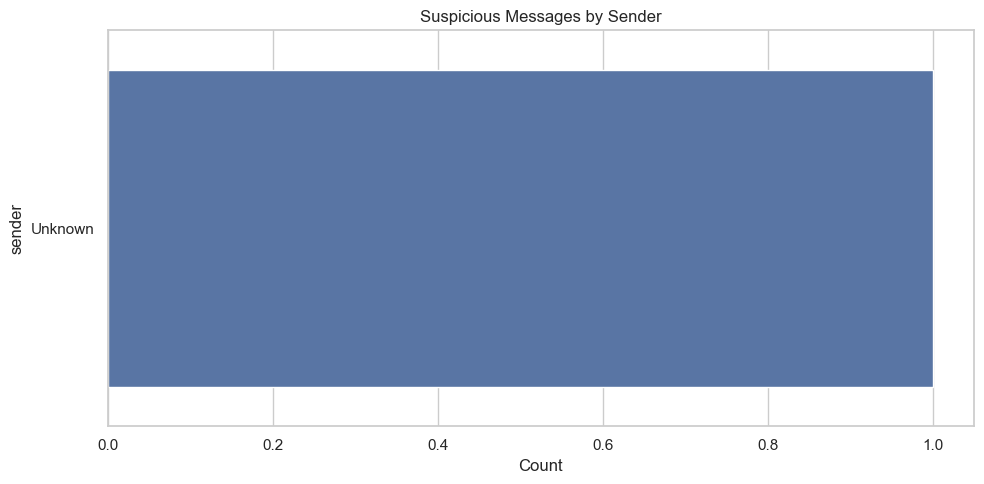

No drug keywords found in suspicious messages.


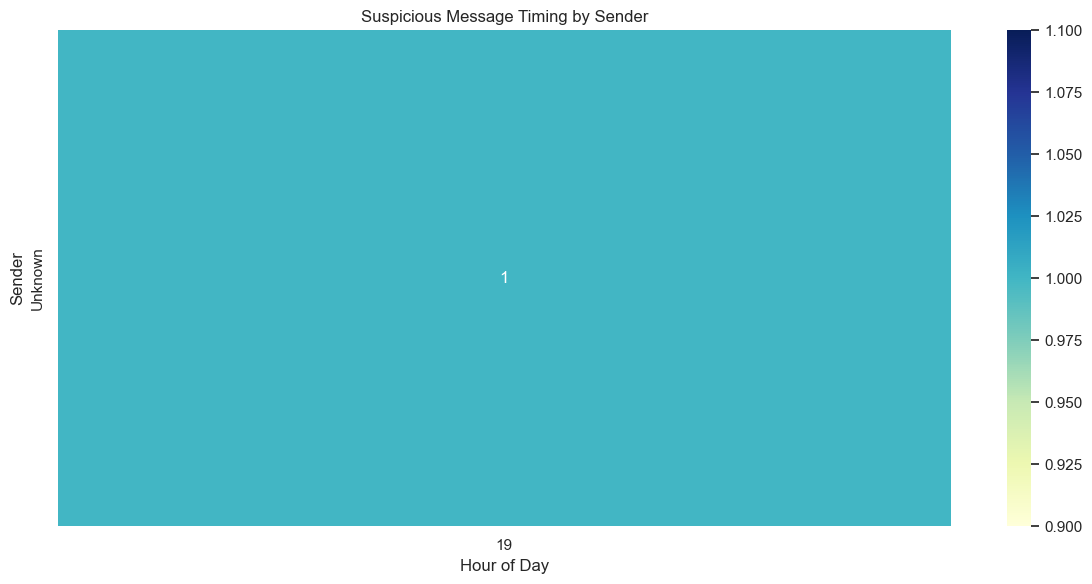

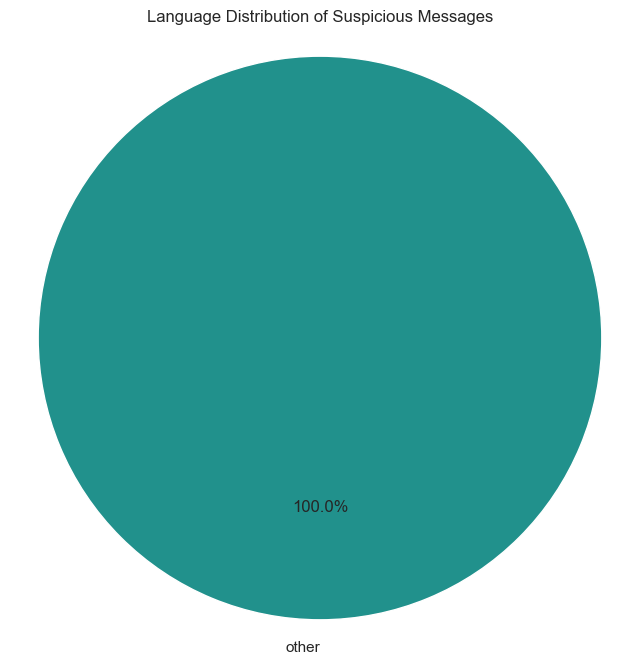

In [4]:
import pandas as pd
import malaya
import spacy
import emoji
import re
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from transformers import pipeline

# ---------------------- Load AI Models ----------------------
print("Loading models...")
lang_model = malaya.language_detection.fasttext()
scispacy_nlp = spacy.load("en_core_sci_sm")
hf_ner = pipeline("ner", model="Davlan/xlm-roberta-base-ner-hrl", 
                  tokenizer="Davlan/xlm-roberta-base-ner-hrl", 
                  aggregation_strategy="simple")
sentiment_analyzer = pipeline(
    "sentiment-analysis",
    model="cardiffnlp/twitter-xlm-roberta-base-sentiment"
)

# ---------------------- Enhanced Drug Keyword Detection ----------------------
# Improved keyword patterns with context awareness
malay_drug_patterns = {
    r'\b(?:ice|ais)\b(?!\s*cream)': 'ice',  # Avoid "ice cream"
    r'\bbatu\b': 'batu',
    r'\bsabu\b': 'sabu',
    r'\bkristal\b': 'kristal',
    r'\bbarang\b': 'barang',
    r'\bstuff\b': 'stuff',
    r'\bline clear\b': 'line clear',
    r'\bchocolate\b': 'chocolate',
    r'\bair\b': 'air',
    r'\bsusu\b': 'susu',
    r'\bubat batuk\b': 'ubat batuk',
    r'\bhappy water\b': 'happy water',
    r'\bpower\b': 'power',
    r'\btopup\b': 'topup',
    r'\bpanadol\b': 'panadol',
    r'\bpil\b': 'pil',
    r'\btest\b': 'test',
    r'\bstok\b': 'stok',
    r'\bdadah\b': 'dadah',
    r'\bmeth\b': 'meth',
    r'\bheroin\b': 'heroin',
    r'\bsyabu\b': 'syabu',
    r'\bganja\b': 'ganja',
    r'\bmarijuana\b': 'marijuana',
    r'\bketamine\b': 'ketamine'
}

chinese_drug_keywords = ['冰毒', '大麻', '可卡因', '摇头丸', '毒品', '海洛因', '毒', '嗨药', '白粉', 'K粉', '毒品交易', '买毒', '卖毒']

# Contextual drug pattern detector
def detect_drug_keywords(text):
    malay_matches = []
    chinese_matches = []
    
    # Detect Malay keywords with context
    for pattern, keyword in malay_drug_patterns.items():
        if re.search(pattern, text, re.IGNORECASE):
            malay_matches.append(keyword)
    
    # Detect Chinese keywords
    for keyword in chinese_drug_keywords:
        if keyword in text:
            chinese_matches.append(keyword)
    
    return malay_matches, chinese_matches

# ---------------------- Personal Info Regex ----------------------
def detect_personal_info(text):
    return {
        'ic': bool(re.search(r'\b\d{6}-\d{2}-\d{4}\b|\b\d{12}\b', text)),
        'bank_account': bool(re.search(r'\b\d{10,16}\b', text)),
        'pin': bool(re.search(r'\b(pin|kod|tac)[^\d]{0,3}(\d{4,6})\b', text, re.IGNORECASE)),
        'password': bool(re.search(r'\b(password|pwd|kata laluan)[^\s]{0,5}[:\-]?\s*\S+', text, re.IGNORECASE)),
        'bank_username': bool(re.search(r'\b(username|akaun|pengguna|user)[^\s]{0,5}[:\-]?\s*\S+', text, re.IGNORECASE))
    }

# ---------------------- Emoji & Reaction Analysis ----------------------
def extract_emojis(text):
    return [e for e in text if e in emoji.EMOJI_DATA]

def detect_reactions(text):
    keywords = ['👍', '❤️', '😢', '😂', '🔥', '💊', '💵', '📦', '💉']
    return [e for e in keywords if e in text]

# ---------------------- NER + Pattern Analysis ----------------------
def analyze_message(row):
    text = str(row['Message'])
    results = {}
    results['sender'] = row.get('Sender', 'Unknown')
    results['language'] = lang_model.predict([text])[0]
    
    # Sentiment analysis
    try:
        sentiment_result = sentiment_analyzer(text)[0]
        results['sentiment'] = sentiment_result['label'].lower()
        results['sentiment_score'] = sentiment_result['score']
    except Exception as e:
        results['sentiment'] = 'error'
        results['sentiment_score'] = 0.0
    
    # Keyword extraction
    try:
        results['keywords'] = [kw for kw, _ in malaya.keyword.extractive.textrank(text)]
    except:
        results['keywords'] = []

    # Using HuggingFace NER
    try:
        hf_entities = hf_ner(text)
        results['huggingface_ner'] = [(e['word'], e['entity_group']) for e in hf_entities]
        results['geo_locations'] = [e['word'] for e in hf_entities if e['entity_group'] in ['LOC', 'GPE']]
        results['hf_persons'] = [e['word'] for e in hf_entities if e['entity_group'] == 'PER']
        results['hf_organizations'] = [e['word'] for e in hf_entities if e['entity_group'] == 'ORG']
    except Exception as e:
        results['huggingface_ner'] = []
        results['geo_locations'] = []
        results['hf_persons'] = []
        results['hf_organizations'] = []

    # SciSpacy NER
    try:
        doc = scispacy_nlp(text)
        results['scispacy_drugs'] = [ent.text for ent in doc.ents if ent.label_.lower() in ['chemical', 'drug', 'pharmacologic_substance']]
    except:
        results['scispacy_drugs'] = []

    # Enhanced keyword detection
    malay_matches, chinese_matches = detect_drug_keywords(text)
    results['malay_drugs'] = malay_matches
    results['chinese_drugs'] = chinese_matches

    # Info Patterns
    results.update(detect_personal_info(text))

    # Emoji/Reactions
    results['emojis'] = extract_emojis(text)
    results['reactions'] = detect_reactions(text)

    # Time
    try:
        time_obj = pd.to_datetime(row['Time (local)'], errors='coerce')
        results['hour'] = time_obj.hour if pd.notnull(time_obj) else None
    except:
        results['hour'] = None

    # Final suspicion score with enhanced logic
    drug_emojis = [r for r in results['reactions'] if r in ['💊', '💵', '💉']]
    has_drug_keywords = any('drug' in kw.lower() for kw in results['keywords'])
    
    results['is_suspicious'] = bool(
        results['malay_drugs'] or 
        results['chinese_drugs'] or 
        results['scispacy_drugs'] or
        results['ic'] or 
        results['bank_account'] or 
        results['pin'] or
        has_drug_keywords or
        drug_emojis
    )
    
    results['suspicion_score'] = (
        len(results['malay_drugs']) + 
        len(results['chinese_drugs']) +
        len(results['scispacy_drugs']) + 
        int(results['ic']) +
        int(results['bank_account']) + 
        int(results['pin']) +
        len(drug_emojis) +
        (1 if has_drug_keywords else 0)
    )

    return results

# ... rest of the code remains the same (analyze_chat_csv, visualize_results, etc.) ...
# ---------------------- Main Processing ----------------------
def analyze_chat_csv(file_path):
    df = pd.read_csv(file_path, encoding='ISO-8859-1')
    if not {'Message', 'Time (local)'}.issubset(df.columns):
        raise ValueError("CSV must contain 'Message' and 'Time (local)' columns")

    df['line_number'] = df.index + 1
    
    # Process in chunks to handle large files
    chunk_size = 100
    chunks = [df[i:i+chunk_size] for i in range(0, len(df), chunk_size)]
    
    results_list = []
    for chunk in chunks:
        analysis = [analyze_message(row) for _, row in chunk.iterrows()]
        results_list.extend(analysis)
    
    results_df = pd.concat([df, pd.DataFrame(results_list)], axis=1)
    return results_df

# ---------------------- Visualizations ----------------------
def visualize_results(results_df):
    sns.set(style="whitegrid")

    # 1. Suspicious messages by sender
    plt.figure(figsize=(10, 5))
    if 'is_suspicious' in results_df.columns and 'sender' in results_df.columns:
        suspicious_df = results_df[results_df['is_suspicious']]
        if not suspicious_df.empty:
            sns.countplot(data=suspicious_df, y='sender', order=suspicious_df['sender'].value_counts().index)
            plt.title("Suspicious Messages by Sender")
            plt.xlabel("Count")
            plt.tight_layout()
            plt.show()
        else:
            print("No suspicious messages found for sender visualization.")
    else:
        print("Missing columns for sender visualization.")

    # 2. Suspicious messages by keyword
    all_drug_keywords = []
    if 'is_suspicious' in results_df.columns:
        for _, row in results_df[results_df['is_suspicious']].iterrows():
            all_drug_keywords.extend(row.get('malay_drugs', []))
            all_drug_keywords.extend(row.get('chinese_drugs', []))
            all_drug_keywords.extend(row.get('scispacy_drugs', []))

    if all_drug_keywords:
        plt.figure(figsize=(12, 6))
        sns.countplot(y=all_drug_keywords, order=pd.Series(all_drug_keywords).value_counts().index)
        plt.title("Top Matched Drug Keywords")
        plt.xlabel("Count")
        plt.tight_layout()
        plt.show()
    else:
        print("No drug keywords found in suspicious messages.")

    # 3. Time heatmap
    if 'hour' in results_df.columns and 'sender' in results_df.columns and 'is_suspicious' in results_df.columns:
        heat_data = results_df[results_df['is_suspicious']].pivot_table(
            index='sender', columns='hour', values='Message', aggfunc='count', fill_value=0
        )
        if not heat_data.empty:
            plt.figure(figsize=(12, 6))
            sns.heatmap(heat_data, cmap="YlGnBu", annot=True, fmt=".0f")
            plt.title("Suspicious Message Timing by Sender")
            plt.xlabel("Hour of Day")
            plt.ylabel("Sender")
            plt.tight_layout()
            plt.show()
        else:
            print("No suspicious messages for timing visualization.")
    else:
        print("Missing columns for time heatmap visualization.")

    # 4. Language distribution
    if 'language' in results_df.columns and 'is_suspicious' in results_df.columns:
        susp_lang_counts = results_df[results_df['is_suspicious']]['language'].value_counts()
        if not susp_lang_counts.empty:
            plt.figure(figsize=(8, 8))
            plt.pie(susp_lang_counts, labels=susp_lang_counts.index, autopct='%1.1f%%', 
                    startangle=90, colors=sns.color_palette("viridis", len(susp_lang_counts)))
            plt.title("Language Distribution of Suspicious Messages")
            plt.axis('equal')
            plt.show()
        else:
            print("No suspicious messages for language visualization.")
    else:
        print("Missing columns for language visualization.")


# ---------------------- Run the Analysis ----------------------
file_path = r'converted_whatsapp_chats.csv'
#file_path = r'Chats.csv'
results = analyze_chat_csv(file_path)
results.to_csv('analyzed_results.csv', index=False)

print("\n--- Top 10 Suspicious Messages ---")
if 'is_suspicious' in results.columns:
    suspicious_df = results[results['is_suspicious']].sort_values(by='suspicion_score', ascending=False).head(10)
    if not suspicious_df.empty:
        print(suspicious_df[['line_number', 'sender', 'Message', 'language', 'sentiment', 
                             'malay_drugs', 'chinese_drugs', 'scispacy_drugs', 
                             'is_suspicious', 'suspicion_score']].to_string())
    else:
        print("No suspicious messages found.")
else:
    print("Suspicious analysis not completed.")

# Show plots
visualize_results(results)

C:\Users\alvin\.conda\envs\suspicious-analysis\lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(
Cannot import beam_search_ops from Tensorflow Addons, ['malaya.jawi_rumi.deep_model', 'malaya.phoneme.deep_model', 'malaya.rumi_jawi.deep_model', 'malaya.stem.deep_model'] will not available to use, make sure Tensorflow Addons version >= 0.12.0
check compatible Tensorflow version with Tensorflow Addons at https://github.com/tensorflow/addons/releases
C:\Users\alvin\.conda\envs\suspicious-analysis\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\alvin\.conda\envs\suspicious-analysis\lib\site-packages\malaya\tokenizer.py:202: FutureWarning: Possible nested set at position 3361
  self.tok 

Loading models...


Device set to use cpu
Device set to use cpu



--- Top 10 Suspicious Messages ---
   line_number   sender     Message language sentiment malay_drugs chinese_drugs scispacy_drugs  is_suspicious  suspicion_score
9           10  Unknown  4907576817    other   neutral          []            []             []           True                1


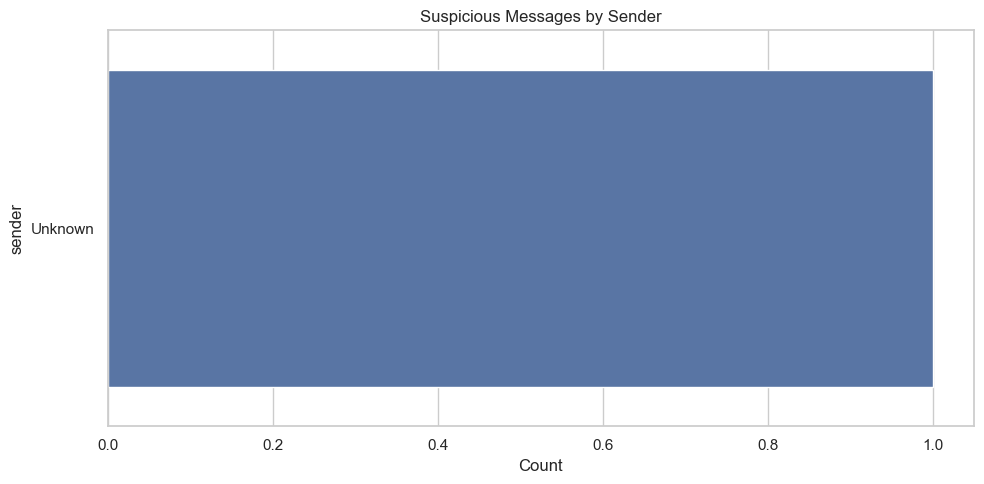

No drug keywords found in suspicious messages.


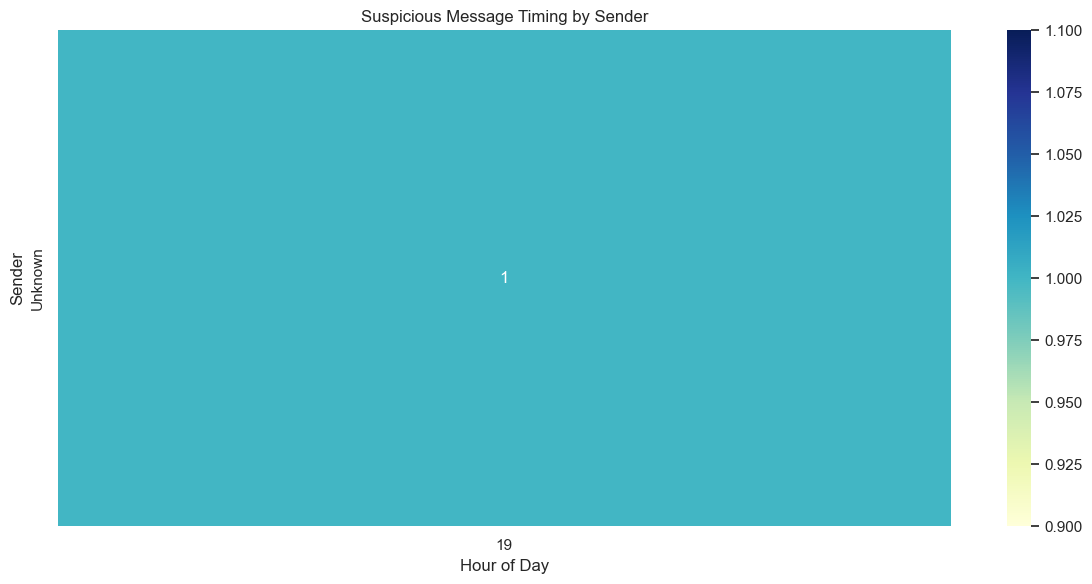

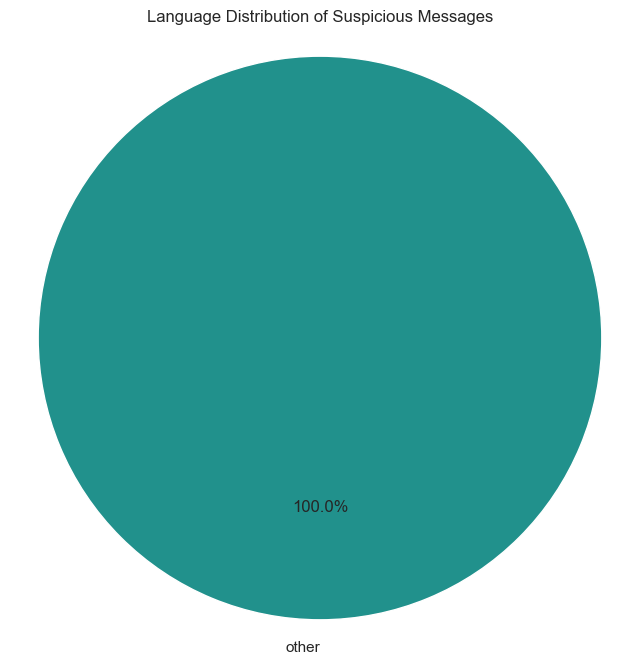

In [1]:
import pandas as pd
import malaya
import spacy
import emoji
import re
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from transformers import pipeline

# ---------------------- Load AI Models ----------------------
print("Loading models...")
lang_model = malaya.language_detection.fasttext()
scispacy_nlp = spacy.load("en_core_sci_sm")
hf_ner = pipeline("ner", model="Davlan/xlm-roberta-base-ner-hrl", 
                  tokenizer="Davlan/xlm-roberta-base-ner-hrl", 
                  aggregation_strategy="simple")
sentiment_analyzer = pipeline(
    "sentiment-analysis",
    model="cardiffnlp/twitter-xlm-roberta-base-sentiment"
)

# ---------------------- Enhanced Drug Keyword Detection ----------------------
# Improved keyword patterns with context awareness
malay_drug_patterns = {
    r'\b(?:ice|ais)\b(?!\s*cream)': 'ice',  # Avoid "ice cream"
    r'\bbatu\b': 'batu',
    r'\bsabu\b': 'sabu',
    r'\bkristal\b': 'kristal',
    r'\bbarang\b': 'barang',
    r'\bstuff\b': 'stuff',
    r'\bline clear\b': 'line clear',
    r'\bchocolate\b': 'chocolate',
    r'\bair\b': 'air',
    r'\bsusu\b': 'susu',
    r'\bubat batuk\b': 'ubat batuk',
    r'\bhappy water\b': 'happy water',
    r'\bpower\b': 'power',
    r'\btopup\b': 'topup',
    r'\bpanadol\b': 'panadol',
    r'\bpil\b': 'pil',
    r'\btest\b': 'test',
    r'\bstok\b': 'stok',
    r'\bdadah\b': 'dadah',
    r'\bmeth\b': 'meth',
    r'\bheroin\b': 'heroin',
    r'\bsyabu\b': 'syabu',
    r'\bganja\b': 'ganja',
    r'\bmarijuana\b': 'marijuana',
    r'\bketamine\b': 'ketamine'
}

chinese_drug_keywords = ['冰毒', '大麻', '可卡因', '摇头丸', '毒品', '海洛因', '毒', '嗨药', '白粉', 'K粉', '毒品交易', '买毒', '卖毒']

# Contextual drug pattern detector
def detect_drug_keywords(text):
    malay_matches = []
    chinese_matches = []
    
    # Detect Malay keywords with context
    for pattern, keyword in malay_drug_patterns.items():
        if re.search(pattern, text, re.IGNORECASE):
            malay_matches.append(keyword)
    
    # Detect Chinese keywords
    for keyword in chinese_drug_keywords:
        if keyword in text:
            chinese_matches.append(keyword)
    
    return malay_matches, chinese_matches

# ---------------------- Personal Info Regex ----------------------
def detect_personal_info(text):
    return {
        'ic': bool(re.search(r'\b\d{6}-\d{2}-\d{4}\b|\b\d{12}\b', text)),
        'bank_account': bool(re.search(r'\b\d{10,16}\b', text)),
        'pin': bool(re.search(r'\b(pin|kod|tac)[^\d]{0,3}(\d{4,6})\b', text, re.IGNORECASE)),
        'password': bool(re.search(r'\b(password|pwd|kata laluan)[^\s]{0,5}[:\-]?\s*\S+', text, re.IGNORECASE)),
        'bank_username': bool(re.search(r'\b(username|akaun|pengguna|user)[^\s]{0,5}[:\-]?\s*\S+', text, re.IGNORECASE))
    }

# ---------------------- Emoji & Reaction Analysis ----------------------
def extract_emojis(text):
    return [e for e in text if e in emoji.EMOJI_DATA]

def detect_reactions(text):
    keywords = ['👍', '❤️', '😢', '😂', '🔥', '💊', '💵', '📦', '💉']
    return [e for e in keywords if e in text]

# ---------------------- NER + Pattern Analysis ----------------------
def analyze_message(row):
    text = str(row['Message'])
    results = {}
    results['sender'] = row.get('Sender', 'Unknown')
    results['language'] = lang_model.predict([text])[0]
    
    # Sentiment analysis
    try:
        sentiment_result = sentiment_analyzer(text)[0]
        results['sentiment'] = sentiment_result['label'].lower()
        results['sentiment_score'] = sentiment_result['score']
    except Exception as e:
        results['sentiment'] = 'error'
        results['sentiment_score'] = 0.0
    
    # Keyword extraction
    try:
        results['keywords'] = [kw for kw, _ in malaya.keyword.extractive.textrank(text)]
    except:
        results['keywords'] = []

    # Using HuggingFace NER
    try:
        hf_entities = hf_ner(text)
        results['huggingface_ner'] = [(e['word'], e['entity_group']) for e in hf_entities]
        results['geo_locations'] = [e['word'] for e in hf_entities if e['entity_group'] in ['LOC', 'GPE']]
        results['hf_persons'] = [e['word'] for e in hf_entities if e['entity_group'] == 'PER']
        results['hf_organizations'] = [e['word'] for e in hf_entities if e['entity_group'] == 'ORG']
    except Exception as e:
        results['huggingface_ner'] = []
        results['geo_locations'] = []
        results['hf_persons'] = []
        results['hf_organizations'] = []

    # SciSpacy NER
    try:
        doc = scispacy_nlp(text)
        results['scispacy_drugs'] = [ent.text for ent in doc.ents if ent.label_.lower() in ['chemical', 'drug', 'pharmacologic_substance']]
    except:
        results['scispacy_drugs'] = []

    # Enhanced keyword detection
    malay_matches, chinese_matches = detect_drug_keywords(text)
    results['malay_drugs'] = malay_matches
    results['chinese_drugs'] = chinese_matches

    # Info Patterns
    results.update(detect_personal_info(text))

    # Emoji/Reactions
    results['emojis'] = extract_emojis(text)
    results['reactions'] = detect_reactions(text)

    # Time
    try:
        time_obj = pd.to_datetime(row['Time (local)'], errors='coerce')
        results['hour'] = time_obj.hour if pd.notnull(time_obj) else None
    except:
        results['hour'] = None

    # Final suspicion score with enhanced logic
    drug_emojis = [r for r in results['reactions'] if r in ['💊', '💵', '💉']]
    has_drug_keywords = any('drug' in kw.lower() for kw in results['keywords'])
    
    results['is_suspicious'] = bool(
        results['malay_drugs'] or 
        results['chinese_drugs'] or 
        results['scispacy_drugs'] or
        results['ic'] or 
        results['bank_account'] or 
        results['pin'] or
        has_drug_keywords or
        drug_emojis
    )
    
    results['suspicion_score'] = (
        len(results['malay_drugs']) + 
        len(results['chinese_drugs']) +
        len(results['scispacy_drugs']) + 
        int(results['ic']) +
        int(results['bank_account']) + 
        int(results['pin']) +
        len(drug_emojis) +
        (1 if has_drug_keywords else 0)
    )

    return results

# ... rest of the code remains the same (analyze_chat_csv, visualize_results, etc.) ...
# ---------------------- Main Processing ----------------------
def analyze_chat_csv(file_path):
    df = pd.read_csv(file_path, encoding='ISO-8859-1')
    if not {'Message', 'Time (local)'}.issubset(df.columns):
        raise ValueError("CSV must contain 'Message' and 'Time (local)' columns")

    df['line_number'] = df.index + 1
    
    # Process in chunks to handle large files
    chunk_size = 100
    chunks = [df[i:i+chunk_size] for i in range(0, len(df), chunk_size)]
    
    results_list = []
    for chunk in chunks:
        analysis = [analyze_message(row) for _, row in chunk.iterrows()]
        results_list.extend(analysis)
    
    results_df = pd.concat([df, pd.DataFrame(results_list)], axis=1)
    return results_df

# ---------------------- Visualizations ----------------------
def visualize_results(results_df):
    sns.set(style="whitegrid")

    # 1. Suspicious messages by sender
    plt.figure(figsize=(10, 5))
    if 'is_suspicious' in results_df.columns and 'sender' in results_df.columns:
        suspicious_df = results_df[results_df['is_suspicious']]
        if not suspicious_df.empty:
            sns.countplot(data=suspicious_df, y='sender', order=suspicious_df['sender'].value_counts().index)
            plt.title("Suspicious Messages by Sender")
            plt.xlabel("Count")
            plt.tight_layout()
            plt.show()
        else:
            print("No suspicious messages found for sender visualization.")
    else:
        print("Missing columns for sender visualization.")

    # 2. Suspicious messages by keyword
    all_drug_keywords = []
    if 'is_suspicious' in results_df.columns:
        for _, row in results_df[results_df['is_suspicious']].iterrows():
            all_drug_keywords.extend(row.get('malay_drugs', []))
            all_drug_keywords.extend(row.get('chinese_drugs', []))
            all_drug_keywords.extend(row.get('scispacy_drugs', []))

    if all_drug_keywords:
        plt.figure(figsize=(12, 6))
        sns.countplot(y=all_drug_keywords, order=pd.Series(all_drug_keywords).value_counts().index)
        plt.title("Top Matched Drug Keywords")
        plt.xlabel("Count")
        plt.tight_layout()
        plt.show()
    else:
        print("No drug keywords found in suspicious messages.")

    # 3. Time heatmap
    if 'hour' in results_df.columns and 'sender' in results_df.columns and 'is_suspicious' in results_df.columns:
        heat_data = results_df[results_df['is_suspicious']].pivot_table(
            index='sender', columns='hour', values='Message', aggfunc='count', fill_value=0
        )
        if not heat_data.empty:
            plt.figure(figsize=(12, 6))
            sns.heatmap(heat_data, cmap="YlGnBu", annot=True, fmt=".0f")
            plt.title("Suspicious Message Timing by Sender")
            plt.xlabel("Hour of Day")
            plt.ylabel("Sender")
            plt.tight_layout()
            plt.show()
        else:
            print("No suspicious messages for timing visualization.")
    else:
        print("Missing columns for time heatmap visualization.")

    # 4. Language distribution
    if 'language' in results_df.columns and 'is_suspicious' in results_df.columns:
        susp_lang_counts = results_df[results_df['is_suspicious']]['language'].value_counts()
        if not susp_lang_counts.empty:
            plt.figure(figsize=(8, 8))
            plt.pie(susp_lang_counts, labels=susp_lang_counts.index, autopct='%1.1f%%', 
                    startangle=90, colors=sns.color_palette("viridis", len(susp_lang_counts)))
            plt.title("Language Distribution of Suspicious Messages")
            plt.axis('equal')
            plt.show()
        else:
            print("No suspicious messages for language visualization.")
    else:
        print("Missing columns for language visualization.")


# ---------------------- Run the Analysis ----------------------
file_path = r'converted_whatsapp_chats.csv'
#file_path = r'Chats.csv'
results = analyze_chat_csv(file_path)
results.to_csv('analyzed_results.csv', index=False)

print("\n--- Top 10 Suspicious Messages ---")
if 'is_suspicious' in results.columns:
    suspicious_df = results[results['is_suspicious']].sort_values(by='suspicion_score', ascending=False).head(10)
    if not suspicious_df.empty:
        print(suspicious_df[['line_number', 'sender', 'Message', 'language', 'sentiment', 
                             'malay_drugs', 'chinese_drugs', 'scispacy_drugs', 
                             'is_suspicious', 'suspicion_score']].to_string())
    else:
        print("No suspicious messages found.")
else:
    print("Suspicious analysis not completed.")

# Show plots
visualize_results(results)

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from drug_scorer import score_message, is_drug  # <-- GA scorer

# ---------------------- Main Processing ----------------------
def analyze_chat_csv(file_path):
    df = pd.read_csv(file_path, encoding='ISO-8859-1')
    if not {'Message', 'Time (local)'}.issubset(df.columns):
        raise ValueError("CSV must contain 'Message' and 'Time (local)' columns")

    df['line_number'] = df.index + 1

    # Apply GA scorer
    df['suspicion_score'] = df['Message'].apply(score_message)
    df['is_suspicious'] = df['Message'].apply(is_drug)

    return df

# ---------------------- Visualizations ----------------------
def visualize_results(results_df):
    sns.set(style="whitegrid")

    # Suspicious messages by sender
    plt.figure(figsize=(10, 5))
    susp_df = results_df[results_df['is_suspicious']]
    if not susp_df.empty:
        sns.countplot(data=susp_df, y='sender', order=susp_df['sender'].value_counts().index)
        plt.title("Suspicious Messages by Sender")
        plt.xlabel("Count")
        plt.tight_layout()
        plt.show()

    # Suspicion scores distribution
    plt.figure(figsize=(8, 5))
    sns.histplot(results_df['suspicion_score'], bins=20, kde=True)
    plt.title("Suspicion Score Distribution")
    plt.xlabel("Suspicion Score")
    plt.tight_layout()
    plt.show()

    # Time heatmap
    if 'Time (local)' in results_df.columns and 'sender' in results_df.columns:
        results_df['hour'] = pd.to_datetime(results_df['Time (local)'], errors='coerce').dt.hour
        heat_data = susp_df.pivot_table(
            index='sender', columns='hour', values='Message', aggfunc='count', fill_value=0
        )
        if not heat_data.empty:
            plt.figure(figsize=(12, 6))
            sns.heatmap(heat_data, cmap="YlGnBu", annot=True, fmt=".0f")
            plt.title("Suspicious Message Timing by Sender")
            plt.xlabel("Hour of Day")
            plt.ylabel("Sender")
            plt.tight_layout()
            plt.show()

# ---------------------- Run the Analysis ----------------------
file_path = r'converted_whatsapp_chats.csv'
results = analyze_chat_csv(file_path)
results.to_csv('analyzed_results.csv', index=False)

# ---------------------- Top 10 Per Sender ----------------------
print("\n--- Top 10 Suspicious Messages per Sender ---")
susp_df = results[results['is_suspicious']]
if susp_df.empty:
    print("No suspicious messages found.")
else:
    for sender, group in susp_df.groupby('sender'):
        print(f"\n>>> Sender: {sender}")
        top10 = group.sort_values(by='suspicion_score', ascending=False).head(10)
        print(top10[['line_number', 'Message', 'suspicion_score']].to_string(index=False))

# Show plots
visualize_results(results)


ModuleNotFoundError: No module named 'drug_scorer'


--- Top 10 Suspicious Messages per Sender ---

>>> Sender: Alex Campbell
 line_number Message  suspicion_score
         113   stuff         0.468126

>>> Sender: Alfred Luna
 line_number Message  suspicion_score
         973     ice         0.468126

>>> Sender: Alicia Evans
 line_number      Message  suspicion_score
        1479 ambil barang         0.499158

>>> Sender: Allison Gonzalez
 line_number Message  suspicion_score
        1583   syabu         0.499158

>>> Sender: Amanda Johnson
 line_number    Message  suspicion_score
          78 barang ori         0.499158

>>> Sender: Amanda Vazquez
 line_number Message  suspicion_score
         438   stuff         0.468126

>>> Sender: Amber Mitchell
 line_number Message  suspicion_score
         800     ice         0.468126

>>> Sender: Amy Golden MD
 line_number Message  suspicion_score
        1678   syabu         0.499158

>>> Sender: Andre Bradley
 line_number Message  suspicion_score
        1814   syabu         0.499158

>>> Se

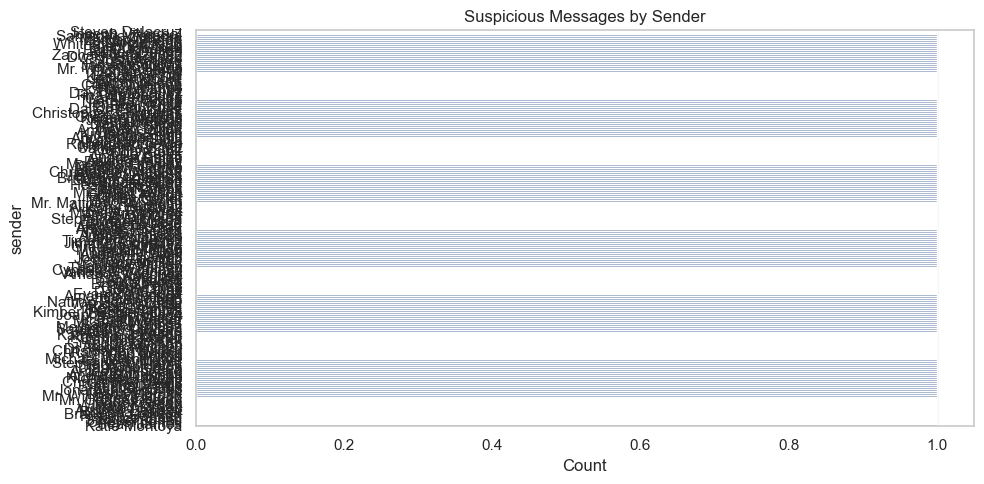

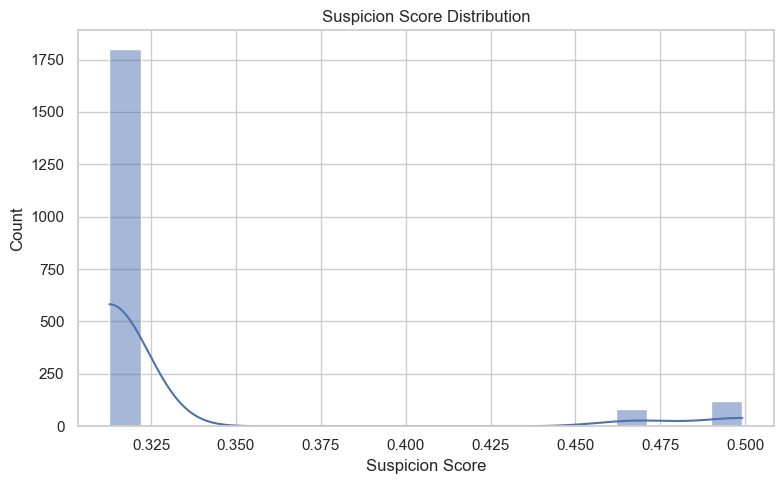

C:\Users\alvin\AppData\Local\Temp\ipykernel_9548\156765400.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  susp_df['hour'] = pd.to_datetime(susp_df['Time (local)'], errors='coerce').dt.hour


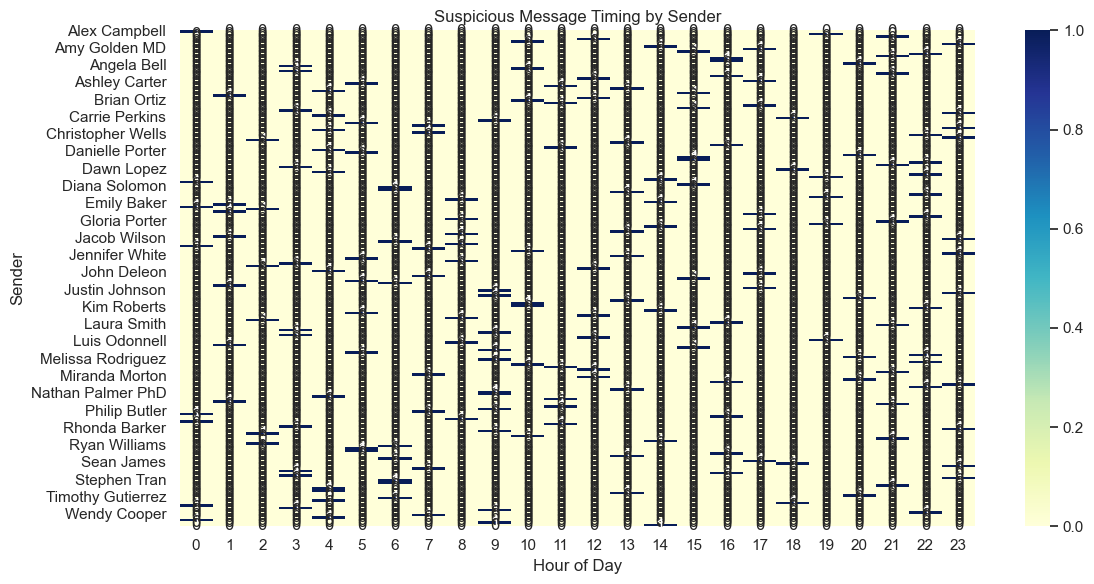

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from drug_scorer import score_message, is_drug  # your GA-based scorer

# ---------------------- Main Processing ----------------------
def analyze_chat_csv(file_path):
    df = pd.read_csv(file_path, encoding='ISO-8859-1')
    
    # check required columns
    if not {'Message', 'Time (local)', 'From'}.issubset(df.columns):
        raise ValueError("CSV must contain 'Message', 'Time (local)', and 'From' columns")
    
    df['line_number'] = df.index + 1
    df = df.rename(columns={'From': 'sender'})
    
    # Apply GA scorer
    df['suspicion_score'] = df['Message'].astype(str).apply(score_message)
    df['is_suspicious'] = df['Message'].astype(str).apply(is_drug)
    
    return df

# ---------------------- Visualizations ----------------------
def visualize_results(results_df):
    sns.set(style="whitegrid")

    # Suspicious messages by sender
    plt.figure(figsize=(10, 5))
    susp_df = results_df[results_df['is_suspicious']]
    if not susp_df.empty:
        sns.countplot(data=susp_df, y='sender', order=susp_df['sender'].value_counts().index)
        plt.title("Suspicious Messages by Sender")
        plt.xlabel("Count")
        plt.tight_layout()
        plt.show()

    # Suspicion scores distribution
    plt.figure(figsize=(8, 5))
    sns.histplot(results_df['suspicion_score'], bins=20, kde=True)
    plt.title("Suspicion Score Distribution")
    plt.xlabel("Suspicion Score")
    plt.tight_layout()
    plt.show()

    # Time heatmap (suspicious only)
    if 'Time (local)' in results_df.columns and 'sender' in results_df.columns:
        susp_df = results_df[results_df['is_suspicious']]
        susp_df['hour'] = pd.to_datetime(susp_df['Time (local)'], errors='coerce').dt.hour
        heat_data = susp_df.pivot_table(
            index='sender', columns='hour', values='Message', aggfunc='count', fill_value=0
        )
        if not heat_data.empty:
            plt.figure(figsize=(12, 6))
            sns.heatmap(heat_data, cmap="YlGnBu", annot=True, fmt=".0f")
            plt.title("Suspicious Message Timing by Sender")
            plt.xlabel("Hour of Day")
            plt.ylabel("Sender")
            plt.tight_layout()
            plt.show()

# ---------------------- Run the Analysis ----------------------
file_path = r'whatsapp_drug_chats.csv'
#file_path = r'Chats.csv'
results = analyze_chat_csv(file_path)

# save results with scores
results.to_csv('whatsapp_chats_scored.csv', index=False)

# ---------------------- Top 10 Per Sender ----------------------
print("\n--- Top 10 Suspicious Messages per Sender ---")
susp_df = results[results['is_suspicious']]
if susp_df.empty:
    print("No suspicious messages found.")
else:
    for sender, group in susp_df.groupby('sender'):
        print(f"\n>>> Sender: {sender}")
        top10 = group.sort_values(by='suspicion_score', ascending=False).head(10)
        print(top10[['line_number', 'Message', 'suspicion_score']].to_string(index=False))

# Show plots
visualize_results(results)
